Датасет с фильмами: https://grouplens.org/datasets/movielens/

In [1]:
import numpy as np
import pandas as pd
import nltk
import time

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics.pairwise import pairwise_distances

import matplotlib.pyplot as plt
%matplotlib inline

C:\Users\vikto\AppData\Roaming\Python\Python39\site-packages\matplotlib\projections\__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


In [2]:
ratings_df = pd.read_csv('./ratings.csv')
print('Количество пользователей: {}'.format(len(ratings_df['userId'].unique())))
print('Количество фильмов: {}'.format(len(ratings_df['movieId'].unique())))
print('Размерность датасета: {}'.format(ratings_df.shape))

ratings_df.head()

Количество пользователей: 610
Количество фильмов: 9724
Размерность датасета: (100836, 4)


,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [3]:
movies_df = pd.read_csv("./movies.csv")
movies_df.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [4]:
tags_df = pd.read_csv("./tags.csv")
tags_df.head()

,userId,movieId,tag,timestamp
0,2,60756,funny,1445714994
1,2,60756,Highly quotable,1445714996
2,2,60756,will ferrell,1445714992
3,2,89774,Boxing story,1445715207
4,2,89774,MMA,1445715200


In [5]:
tags_df = tags_df.drop(["userId", "timestamp"],axis=1)

In [6]:
def tag_converter(tags):
    tags = [str(i) for i in tags]
    return ' '.join(tags)

In [7]:
new_df = movies_df.merge(tags_df, left_on='movieId', right_on='movieId', how="left")

# test = new_df.groupby(["movieId", "genres", "title"])['tag'].apply(tag_converter)
test = new_df.groupby(["movieId", "genres", "title"]).agg(tuple).map(tag_converter).reset_index()
test

,movieId,genres,title,tag
0,1,Adventure|Animation|Children|Comedy|Fantasy,Toy Story (1995),pixar pixar fun
1,2,Adventure|Children|Fantasy,Jumanji (1995),fantasy magic board game Robin Williams game
2,3,Comedy|Romance,Grumpier Old Men (1995),moldy old
3,4,Comedy|Drama|Romance,Waiting to Exhale (1995),nan
4,5,Comedy,Father of the Bride Part II (1995),pregnancy remake
...,...,...,...,...
9737,193581,Action|Animation|Comedy|Fantasy,Black Butler: Book of the Atlantic (2017),nan
9738,193583,Animation|Comedy|Fantasy,No Game No Life: Zero (2017),nan
9739,193585,Drama,Flint (2017),nan
9740,193587,Action|Animation,Bungo Stray Dogs: Dead Apple (2018),nan


In [8]:
# Отберём для тестирования часть набора и отмасштабируем для удобства идентификаторы фильмов так,
# чтобы они начинались с 1 и заканчивались на n_movies:

# n = 100000
ratings_df_sample = ratings_df

n_users = len(ratings_df_sample['userId'].unique())
n_movies = len(ratings_df_sample['movieId'].unique())
(n_users, n_movies)


(610, 9724)

In [9]:
movie_ids = ratings_df_sample['movieId'].unique()

def scale_movie_id(movie_id):
    scaled = np.where(movie_ids == movie_id)[0][0] + 1
    return scaled

ratings_df_sample['movieId'] = ratings_df_sample['movieId'].apply(scale_movie_id)
ratings_df_sample.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,2,4.0,964981247
2,1,3,4.0,964982224
3,1,4,5.0,964983815
4,1,5,5.0,964982931


In [10]:
from sklearn.model_selection import train_test_split
# обучающий и тестовый наборы
train_data, test_data = train_test_split(ratings_df_sample, test_size=0.01)

In [11]:
# Сформируем матрицы размера (n_users, n_movies) для обучающего и тестового наборов, в которых
# элемент в ячейке [i, j] отражает оценку i-го пользователя j-му фильму
    
train_data_matrix = np.zeros((n_users, n_movies))
for line in train_data.itertuples():
    train_data_matrix[line[1] - 1, line[2] - 1] = line[3]
    
test_data_matrix = np.zeros((n_users, n_movies))
for line in test_data.itertuples():
    test_data_matrix[line[1] - 1, line[2] - 1] = line[3]

In [12]:
from  sklearn.metrics.pairwise import pairwise_distances
# ключевое в алгоритме -- мера близости
# считаем косинусное расстояние для пользователей и фильмов (построчно и поколоночно соотвественно)

# Valid values for metric are:
# [‘cityblock’, ‘cosine’, ‘euclidean’, ‘l1’, ‘l2’, ‘manhattan’]
# [‘nan_euclidean’]
# [‘braycurtis’, ‘canberra’, ‘chebyshev’, ‘correlation’, ‘dice’,
#  ‘hamming’, ‘jaccard’, ‘kulsinski’, ‘mahalanobis’, ‘minkowski’,
#  ‘rogerstanimoto’, ‘russellrao’, ‘seuclidean’, ‘sokalmichener’,
#  ‘sokalsneath’, ‘sqeuclidean’, ‘yule’]

# подходят евклидово, косинусное, корреляция 

user_similarity = pairwise_distances(train_data_matrix, metric='cosine')

In [13]:
def steam_game_recommender(title, cosine_sim, dataframe, count):
    indices = pd.Series(dataframe.index, index=dataframe['title'])
    indices = indices[~indices.index.duplicated(keep='last')]
    game_index = indices[title]
    similarity_scores = pd.DataFrame(cosine_sim[game_index], columns=["score"])
    game_indices = similarity_scores.sort_values("score", ascending=False)[0:count].index
    result = dataframe.loc[dataframe['movieId'].isin(game_indices)]
    return result

In [14]:
stopwords = ["nan"]

tfidf = TfidfVectorizer(
                     use_idf=True,
                     min_df=0.01,
                     ngram_range=(1,3),
                     stop_words=stopwords
                    )

In [15]:
# объединяем столбики с описаниями, чтобы получить больше информации о каждой игре и обработать тфидф-ом
tfidf_matrix = tfidf.fit_transform(
    test["genres"] + "\n" + test["tag"]
)

tfidf_matrix.shape

cosine_sim = cosine_similarity(tfidf_matrix, tfidf_matrix) # pairwise_distances(tfidf_matrix, metric='euclidean') #

cosine_sim.shape

(9742, 9742)

numpy.ndarray

In [33]:
def predict_for_single_user(userID):
    userFilms = train_data_matrix[userID]
    # Для каждого пользователя необходимо получить наиболее похожих пользователей:
    # Нулевой элемент не подходит, т.к. на этом месте находится похожесть пользователя самого на себя
    top_sim_users = user_similarity[userID].argsort()[1]
    # берём только оценки из "обучающей" выборки 
    top_similar_ratings = train_data_matrix[top_sim_users]
    pred = top_similar_ratings
    for i, old in enumerate(userFilms):
        if old != 0:
            pred[i] = 0
    pred2 = pred.argsort()[::-1][:5]    
    result = test.loc[test['movieId'].isin(pred2)]
    return result

# гибридное
def predict_user(userID):
    result = predict_for_single_user(userID)
    old = result
    
    for name in old.title:
        res = steam_game_recommender(name, cosine_sim, test, 1)
        i = 2
        while len(res) < 1 and i < 10:
            res = steam_game_recommender(name, cosine_sim, test, i)
            i += 1
        result = pd.concat([result, res])
    return result
    

pred_user = predict_user(4)
pred_user

,movieId,genres,title,tag
2,3,Comedy|Romance,Grumpier Old Men (1995),moldy old
19,20,Action|Comedy|Crime|Drama|Thriller,Money Train (1995),nan
31,32,Mystery|Sci-Fi|Thriller,Twelve Monkeys (a.k.a. 12 Monkeys) (1995),time travel time travel Brad Pitt Bruce Willis...
278,319,Comedy|Drama|Thriller,Shallow Grave (1994),nan
449,514,Comedy,"Ref, The (1994)",nan
2977,3989,Documentary,One Day in September (1999),nan
2736,3674,Adventure|Children|Comedy|Drama,For the Love of Benji (1977),nan
240,278,Comedy,Miami Rhapsody (1995),nan


In [38]:
len(pred_user)

8

In [50]:
"Shallow Grave (1994)" in pred_user.title.to_list()

True

In [37]:
steam_game_recommender("Wild Bunch, The (1969)", cosine_sim, test, 4)

,movieId,genres,title,tag
450,515,Drama|Romance,"Remains of the Day, The (1993)",Butler Housekeeper
610,766,Drama,I Shot Andy Warhol (1996),nan


7 802
Время на инициализацию с n = 1000: 0.015004158020019531 c
32 2427
Время на инициализацию с n = 5000: 0.0 c


C:\Users\vikto\AppData\Local\Temp\ipykernel_12360\332676286.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings_df_sample['movieId'] = ratings_df_sample['movieId'].apply(scale_movie_id)
C:\Users\vikto\AppData\Local\Temp\ipykernel_12360\332676286.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings_df_sample['movieId'] = ratings_df_sample['movieId'].apply(scale_movie_id)


66 3218
Время на инициализацию с n = 10000: 0.002000093460083008 c
132 4841


C:\Users\vikto\AppData\Local\Temp\ipykernel_12360\332676286.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings_df_sample['movieId'] = ratings_df_sample['movieId'].apply(scale_movie_id)
C:\Users\vikto\AppData\Local\Temp\ipykernel_12360\332676286.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings_df_sample['movieId'] = ratings_df_sample['movieId'].apply(scale_movie_id)


Время на инициализацию с n = 20000: 0.006001710891723633 c
322 6908


C:\Users\vikto\AppData\Local\Temp\ipykernel_12360\332676286.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings_df_sample['movieId'] = ratings_df_sample['movieId'].apply(scale_movie_id)


Время на инициализацию с n = 50000: 0.022005558013916016 c
610 9569


C:\Users\vikto\AppData\Local\Temp\ipykernel_12360\332676286.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings_df_sample['movieId'] = ratings_df_sample['movieId'].apply(scale_movie_id)


Время на инициализацию с n = 100000: 0.06301522254943848 c


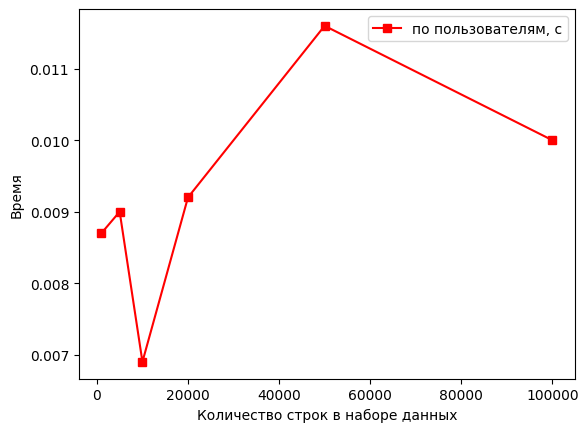

In [19]:
axis_x = ['cosine', 'euclidean', 'correlation']
graph1 = []
graph2 = []

ns = [1000, 5000, 10000, 20000, 50000, 100000]

for n in ns:
    global train_data_matrix
    global test_data_matrix
    global item_similarity
    global user_similarity
    
    ratings_df_sample = ratings_df[:n]
    n_users = len(ratings_df_sample['userId'].unique())
    n_movies = len(ratings_df_sample['movieId'].unique())
    print(n_users, n_movies)
    movie_ids = ratings_df_sample['movieId'].unique()
    ratings_df_sample['movieId'] = ratings_df_sample['movieId'].apply(scale_movie_id)
    train_data, test_data = train_test_split(ratings_df_sample, test_size=0.2)
    train_data_matrix = np.zeros((n_users, n_movies))
    for line in train_data.itertuples():
        train_data_matrix[line[1] - 1, line[2] - 1] = line[3]
    test_data_matrix = np.zeros((n_users, n_movies))
    for line in test_data.itertuples():
        test_data_matrix[line[1] - 1, line[2] - 1] = line[3]
    
    start_time = time.time()
    user_similarity = pairwise_distances(train_data_matrix, metric='cosine')
    end_time = time.time()
    e_time = (end_time - start_time)
    print("Время на инициализацию с n = {}: {} c".format(n, e_time))
    
    e_time1 = 0
    
    for i in range(10):
        start_time = time.time()
#         for i in range(0, 100):
        predict_user(5)
        end_time = time.time()
        e_time1 += (end_time - start_time)
        
    graph1.append(e_time1 / 10)

plt.plot(ns, graph1, marker='s', color='r', label="по пользователям, c");
plt.legend()
plt.xlabel('Количество строк в наборе данных')
plt.ylabel('Время');